In [18]:
import glob
import h5py
import numpy as np
import os
import pylab
import scipy.linalg
import scipy as sp
import sys

from numpy import array, concatenate, zeros
from numpy.random import randn
from scipy.optimize import minimize

from functools import reduce

from openfermion.config import *
#from openfermionprojectq import 
#from openfermionprojectq._unitary_cc import uccsd_trotter_engine

from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, bravyi_kitaev, get_sparse_operator
from openfermion.utils import uccsd_singlet_paramsize, uccsd_singlet_generator
from openfermion.ops import FermionOperator

from openfermionpsi4 import run_psi4

from projectq.ops import X, All, Measure
from projectq.backends import CommandPrinter, CircuitDrawer
from projectq.ops import (BasicGate,
                          H,
                          X,
                          CNOT,
                          Measure,
                          Z,
                          Swap,
                          C,
                          Rx,
                          Rz)
from projectq.backends._circuits import to_latex
from projectq.backends import _printer

%matplotlib inline

hartree_to_kcal = 627.50947415

In [5]:
def canonical_eigh(M, S):
    """Return the eigenvectors and eigenvalues in the original basis with potentially singular S"""
    #Solve for spectrum with canonical orthogonalization
    overlapCutoff = 1.0e-8
    [evals, evecs] = sp.linalg.eigh(S)

    #Determine rank
    RankOverlap = np.sum(evals > overlapCutoff)
    nullity = len(evals) - RankOverlap
    #Cutoff
    evals = evals[nullity:]
    evecs = evecs[:, nullity:]

    #Make transformation matrix
    U = np.dot(evecs, np.diag(evals**(-0.5)))

    #Transform the Hamiltonian and find the new eigenvectors
    M_prime = np.dot(np.conj(U).T, np.dot(M, U))
    S_prime = np.dot(np.conj(U).T, np.dot(S, U))

    e_vals, e_vecs = sp.linalg.eigh(M_prime, S_prime)
    #Transform eigenvectors back to original basis
    e_vecs = np.dot(U, e_vecs)
    
    return e_vals, e_vecs, U

def FindSymmTransform(M, S, val):
    """Find a transform to project onto the eigenspace corresponding to eigenvalue val of operator 
    representation M with overlap S"""
    e_vals, e_vecs, U = canonical_eigh(M, S)
    indices = np.where(np.abs(e_vals-val) < 0.1)[0]
    U = e_vecs[:, indices]
    return U

In [6]:
# Load files
molecule_filenames = sorted(glob.glob('data/*.hdf5'))
test_molecule = MolecularData(filename=molecule_filenames[0])
print("Number of spatial basis functions: {}".format(test_molecule.n_orbitals))
print("Number of electrons: {}".format(test_molecule.n_electrons))
test_molecule = None

Number of spatial basis functions: 52
Number of electrons: 16


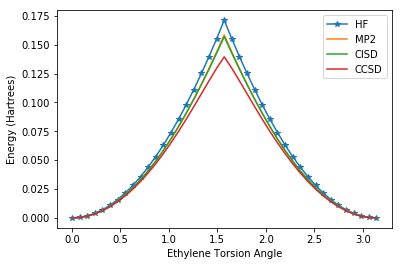

In [7]:
# Plot CCSD curve for angle
angles = []
hf_energies = []
mp2_energies = []
cisd_energies = []
ccsd_energies = []

for filename in molecule_filenames:
    angle = float(filename.split('_')[-1].rstrip('.hdf5'))
    molecule = MolecularData(filename=filename)
    
    angles.append(angle)
    hf_energies.append(molecule.hf_energy)
    mp2_energies.append(molecule.mp2_energy)
    cisd_energies.append(molecule.cisd_energy)
    ccsd_energies.append(molecule.ccsd_energy)

pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Energy (Hartrees)")
pylab.plot(angles, np.array(hf_energies) - hf_energies[0], '*-', label="HF")
pylab.plot(angles, np.array(mp2_energies) - mp2_energies[0], label="MP2")
pylab.plot(angles, np.array(cisd_energies) - cisd_energies[0], label="CISD")
pylab.plot(angles, np.array(ccsd_energies) - ccsd_energies[0], label="CCSD")
pylab.legend()

In [ ]:
# Examine a CAS(n electrons, n spatial orbitals) active space - 2 x number spatial orbitals = qubits
angles = [float(filename.split('_')[-1].rstrip('.hdf5')) for filename in molecule_filenames]
cas_energies = {}
original_electrons = 16
for n_electrons, n_orbitals in [(2,1), (2,2), (4,4)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = get_sparse_operator(jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))).todense()
    spinx_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spiny_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i+1, 0)), -0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i, 0)), 0.5j) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spinz_operator = get_sparse_operator(jordan_wigner(
            sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()) +
            sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                 for i in range(active_qubits // 2)], FermionOperator()))).todense()
    spin2_operator = (np.dot(spinx_operator, spinx_operator) +
                      np.dot(spiny_operator, spiny_operator) +
                      np.dot(spinz_operator, spinz_operator))
    cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
    for filename in molecule_filenames:
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                       get_molecular_hamiltonian(
                           occupied_indices=occupied_indices,
                           active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        # Build qubit Hamiltonian
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)

        # Build matrix representation & diagonalize
        qubit_hamiltonian_matrix = get_sparse_operator(hamiltonian).todense()

        # Project to S^2 = 0 subspace
        U_s2 = FindSymmTransform(spin2_operator, 
                                 np.eye(spin2_operator.shape[0]),
                                 0.0)
        qubit_hamiltonian_matrix = np.dot(np.conj(U_s2).T, np.dot(qubit_hamiltonian_matrix, U_s2))
        
        print('Qubit Hamiltonian Matrix')
        print(qubit_hamiltonian_matrix)
        print()
        
        eigvals, eigvecs = scipy.linalg.eigh(qubit_hamiltonian_matrix)
        ground_state = eigvecs[:,0][:, np.newaxis]
        energy = eigvals[0]
        number = reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, number_operator, U_s2, ground_state))[0,0]
        spinz =  reduce(np.dot,
                        (np.conj(ground_state.T), np.conj(U_s2).T, spinz_operator, U_s2, ground_state))[0,0]
        spin2 =  reduce(np.dot,
                       (np.conj(ground_state.T), np.conj(U_s2).T, spin2_operator, U_s2, ground_state))[0,0]
        
        cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(energy)
        print('Energy: {}\t Number: {}\t Sz:{}\t S^2:{}'.format(energy, number, spinz, spin2))
        
    
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("CAS Energy (kcal/mol)")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

In [ ]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * (np.array(hf_energies) - hf_energies[0]), label="HF")
pylab.plot(angles, hartree_to_kcal * (np.array(mp2_energies) - mp2_energies[0]), label="MP2")
pylab.plot(angles, hartree_to_kcal * (np.array(cisd_energies) - cisd_energies[0]), label="CISD")
pylab.plot(angles, hartree_to_kcal * (np.array(ccsd_energies) - ccsd_energies[0]), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
               label=key)
pylab.legend()

In [ ]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Absolute Energy (kcal/mol)")
pylab.plot(angles, hartree_to_kcal * np.array(hf_energies), label="HF")
pylab.plot(angles, hartree_to_kcal * np.array(mp2_energies), label="MP2")
pylab.plot(angles, hartree_to_kcal * np.array(cisd_energies), label="CISD")
pylab.plot(angles, hartree_to_kcal * np.array(ccsd_energies), label="CCSD")
for key in cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * np.array(cas_energies[key]),
               label=key)
pylab.legend()

In [26]:
# Make a UCC Singlet Ansatz for CAS(2,2) at a particular geometry
uccsd_energies = {}
uccsd_amplitudes = {}
original_electrons = 16
for n_electrons, n_orbitals in [(2,2)]:
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
    number_operator.compress()
    spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()) +
                                   sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()))
    spinz_operator.compress()
    
    n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, 
                                           active_electrons))
    print("Running CAS({},{}) with {} coupled cluster amplitudes".format(n_electrons, n_orbitals,n_amplitudes))
    current_amplitudes = [0.2] * n_amplitudes + 0.001 * randn(n_amplitudes)
    uccsd_energies['CAS({},{})'.format(n_electrons, n_orbitals)] = []
    uccsd_amplitudes['CAS({},{})'.format(n_electrons, n_orbitals)] = []

    for file_index, filename in enumerate(molecule_filenames):
        print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
        molecule = MolecularData(filename=filename)
        # Extract active space integrals
        hamiltonian = (molecule.
                       get_molecular_hamiltonian(
                           occupied_indices=occupied_indices,
                           active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        print(fermion_hamiltonian)
        # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
        print(qubit_hamiltonian)
        qubit_hamiltonian.compress()
        
        # Set standard UCCSD Compiler engine
        #compiler_engine = uccsd_trotter_engine()

        def energy_objective(packed_amplitudes):
            """Evaluate the energy of a UCCSD singlet wavefunction with packed_amplitudes
            Args:
                packed_amplitudes(ndarray): Compact array that stores the unique
                    amplitudes for a UCCSD singlet wavefunction.

            Returns:
                energy(float): Energy corresponding to the given amplitudes
            """
            # Set Jordan-Wigner initial state with correct number of electrons
            #wavefunction = compiler_engine.allocate_qureg(active_qubits)
            
            # Set some of the qubits to |1>, or occupied
           # for i in range(active_electrons):
           #     X | wavefunction[i]

            # Build the circuit and act it on the wavefunction
            evolution_operator = uccsd_singlet_generator(packed_amplitudes, 
                                                         active_qubits, active_electrons)
            print("NEWNEWNEWNEW")
            print(evolution_operator)
            print('TRANSFORMED')
            evol_jw=jordan_wigner(evolution_operator)
            print(evol_jw)
            print('COMPRESS')
            print(evol_jw.compress())
            #evolution_operator | wavefunction
            #compiler_engine.flush()

            # Evaluate the energy and reset wavefunction
            #energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
            #number = compiler_engine.backend.get_expectation_value(number_operator, wavefunction)
            #spinz = compiler_engine.backend.get_expectation_value(spinz_operator, wavefunction)
            #print("Energy: {}\t Number:{}\t Sz:{}".format(energy, number, spinz))
            #All(Measure) | wavefunction
            energy=0
            #compiler_engine.flush()
            return energy

        initial_energy = energy_objective(current_amplitudes)

        # Run VQE Optimization to find new CCSD parameters
        opt_result = minimize(energy_objective, current_amplitudes,
                              method="l-bfgs-b", options={'disp':True})

        opt_energy, opt_amplitudes = opt_result.fun, opt_result.x

        # Use previous interation as guess for next iteration
        current_amplitudes = opt_amplitudes[:]

        # Store energy and amplitudes
        uccsd_energies['CAS({},{})'.format(n_electrons, n_orbitals)].append(opt_energy)
        uccsd_amplitudes['CAS({},{})'.format(n_electrons, n_orbitals)].append([opt_amplitudes])

        print("\nInitial Energy: {}".format(initial_energy))
        print("Optimal UCCSD Singlet Energy: {}".format(opt_energy))
        print("Optimal UCCSD Singlet Amplitudes: {}".format(opt_amplitudes))
        print("Exact FCI Energy: {} Hartrees".format(
                cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))


Running CAS(2,2) with 2 coupled cluster amplitudes
Running CAS(2,2) on data/H4-C2_DZP_singlet_ethylene_0.00000.hdf5
-76.86638025450547 [] +
-0.8107003490615307 [0^ 0] +
0.2194320533986508 [0^ 1^ 1 0] +
0.0452018005598162 [0^ 1^ 3 2] +
0.04520180055981617 [0^ 2^ 0 2] +
0.18143769455049882 [0^ 2^ 2 0] +
0.04520180055981617 [0^ 3^ 1 2] +
0.18143769455049882 [0^ 3^ 3 0] +
0.2194320533986508 [1^ 0^ 0 1] +
0.0452018005598162 [1^ 0^ 2 3] +
-0.8107003490615307 [1^ 1] +
0.04520180055981617 [1^ 2^ 0 3] +
0.18143769455049882 [1^ 2^ 2 1] +
0.04520180055981617 [1^ 3^ 1 3] +
0.18143769455049882 [1^ 3^ 3 1] +
0.18143769455049896 [2^ 0^ 0 2] +
0.04520180055981622 [2^ 0^ 2 0] +
0.18143769455049896 [2^ 1^ 1 2] +
0.04520180055981622 [2^ 1^ 3 0] +
-0.4881558809087164 [2^ 2] +
0.04520180055981618 [2^ 3^ 1 0] +
0.1647305127940013 [2^ 3^ 3 2] +
0.18143769455049896 [3^ 0^ 0 3] +
0.04520180055981622 [3^ 0^ 2 1] +
0.18143769455049896 [3^ 1^ 1 3] +
0.04520180055981622 [3^ 1^ 3 1] +
0.04520180055981618 [3^ 2^ 0 1

NameError: name 'cas_energies' is not defined

In [ ]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
for key in ['CAS(2,2)', 'CAS(4,4)']: #cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
              label=key)
for key in uccsd_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(uccsd_energies[key]) - uccsd_energies[key][0]),
               label="UCCSD-" + key)
pylab.legend()
pylab.savefig("Ethylene_UCCSD_4Qubit.pdf")

In [ ]:
# Print out the commands submitted to the engine
cmd_printer = _printer.CommandPrinter()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = uccsd_trotter_engine(cmd_printer)
wavefunction = []
wavefunction = compiler_engine.allocate_qureg(active_qubits)
for i in range(active_electrons):
    X | wavefunction[i]
evolution_operator = uccsd_singlet_evolution(packed_amplitudes, active_qubits, active_electrons)
evolution_operator | wavefunction
compiler_engine.flush()

In [ ]:
# Generate the circuit diagram and print it
drawer = CircuitDrawer()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = uccsd_trotter_engine(drawer)
wavefunction = []
wavefunction = compiler_engine.allocate_qureg(active_qubits)
for i in range(active_electrons):
    X | wavefunction[i]
evolution_operator = uccsd_singlet_evolution(packed_amplitudes, active_qubits, active_electrons)
evolution_operator | wavefunction
compiler_engine.flush()
circuit = drawer.get_latex()
print(circuit)

In [ ]:
# Make a custom ansatz for CAS(2,2) at a particular geometry
# UCCSD has only one single and one double excitation operator; The custom ansatz only tackles the double exitation
from projectq import MainEngine
from projectq.ops import H, X, Rz, Rx, CNOT
from projectq.meta import Control

mini_energies = {}
mini_amplitudes = {}
original_electrons = 16
n_electrons = 2
n_orbitals = 2
for target_flip in range(4):
    print("\n\nTarget flip {} ...\n\n".format(target_flip))
    occupied_indices = range(8 - n_electrons // 2)
    active_indices = range(8 - n_electrons // 2, 8 - n_electrons // 2 + n_orbitals)
    active_electrons = original_electrons - len(occupied_indices) * 2
    active_qubits = len(active_indices) * 2

    # Define a qubit number operator
    number_operator = jordan_wigner(
        sum([FermionOperator( ((i, 1), (i, 0)), 1.0) for i in range(active_qubits)], FermionOperator()))
    number_operator.compress()
    spinz_operator = jordan_wigner(sum([FermionOperator( ((2*i, 1), (2*i, 0)), 0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()) +
                                   sum([FermionOperator( ((2*i+1, 1), (2*i+1, 0)), -0.5) 
                                        for i in range(active_qubits // 2)], FermionOperator()))
    spinz_operator.compress()

    n_amplitudes = 1
    current_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
    
    # Printout formatting
    mini_energies['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)] = []
    mini_amplitudes['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)] = []

    for file_index, filename in enumerate(molecule_filenames):
        print("Running CAS({},{}) on {}".format(n_electrons, n_orbitals, filename))
        molecule = MolecularData(filename=filename)
            
        # Extract active space integrals
        hamiltonian = (molecule.
                        get_molecular_hamiltonian(
                        occupied_indices=occupied_indices,
                        active_indices=active_indices))
        fermion_hamiltonian = get_fermion_operator(hamiltonian)

        # For comparison, do a Bravyi-Kitaev encoding, compress to remove 0 imaginary components and print
        qubit_hamiltonian = bravyi_kitaev(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        print('Bravyi-Kitaev')
        print(qubit_hamiltonian)
        
        # Use a Jordan-Wigner encoding, and compress to remove 0 imaginary components and print
        qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
        qubit_hamiltonian.compress()
        print('Jordan-Wigner')
        print(qubit_hamiltonian)
        
        # Set standard UCCSD Compiler engine
        compiler_engine = MainEngine()

        def energy_objective(packed_amplitudes):
            """Evaluate the energy of a mini singlet wavefunction with packed_amplitudes
                Args:
                packed_amplitudes(ndarray): Compact array that stores the unique
                    amplitudes

                Returns:
                    energy(float): Energy corresponding to the given amplitudes
            """
            
            # Allocate qubits
            wavefunction = compiler_engine.allocate_qureg(active_qubits)

            # Set Jordan-Wigner initial state with correct number of electrons 
            for i in range(active_electrons):
                X | wavefunction[i]

            # Build the circuit and act it on the wavefunction
            # Apply Hadamard gate to all qubits
            for i in range(active_qubits):
                H | wavefunction[i]

            # Undo the Hadamard on one qubit and apply Rx
            H | wavefunction[target_flip]
            Rx(-np.pi/2) | wavefunction[target_flip]

            # Entangle qubits with CNOTs
            for i in range(active_qubits-1):
                CNOT | (wavefunction[i], wavefunction[i+1])
            
            # UCCSD exponent rotation Rz
            Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]

            # Reverse CNOTs
            for i in reversed(range(active_qubits-1)):
                CNOT | (wavefunction[i], wavefunction[i+1])

            # Undo Hadamard
            for i in range(active_qubits):
                H | wavefunction[i]

            # Rotate the one qubit back with -Rx
            H | wavefunction[target_flip]
            Rx(np.pi/2) | wavefunction[target_flip]

            # Reset of qubits
            compiler_engine.flush()

            # Evaluate the energy and reset wavefunction
            energy = compiler_engine.backend.get_expectation_value(qubit_hamiltonian, wavefunction)
            number = compiler_engine.backend.get_expectation_value(number_operator, wavefunction)
            spinz = compiler_engine.backend.get_expectation_value(spinz_operator, wavefunction)
            print("Energy: {}\t Number:{}\t Sz:{}".format(energy, number, spinz))
            All(Measure) | wavefunction
            compiler_engine.flush()
            return energy

        initial_energy = energy_objective(current_amplitudes)

        # Run VQE Optimization to find new CCSD parameters
        opt_result = minimize(energy_objective, current_amplitudes,
                                method="l-bfgs-b", options={'disp':True})

        opt_energy, opt_amplitudes = opt_result.fun, opt_result.x

        # Use previous interation as guess for next iteration
        current_amplitudes = opt_amplitudes[:]

        # Store energy and amplitudes
        mini_energies['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)].append(opt_energy)
        mini_amplitudes['CAS({},{})-{}'.format(n_electrons, n_orbitals, target_flip)].append([opt_amplitudes])

        print("\nInitial Energy: {}".format(initial_energy))
        print("Optimal mini Singlet Energy: {}".format(opt_energy))
        print("Optimal mini Singlet Amplitudes: {}".format(opt_amplitudes))
        print("Exact FCI Energy: {} Hartrees".format(
                cas_energies['CAS({},{})'.format(n_electrons, n_orbitals)][file_index]))

In [ ]:
# Print out the commands submitted to the engine
cmd_printer = _printer.CommandPrinter()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = MainEngine(cmd_printer)
wavefunction = []
# Allocate qubits
wavefunction = compiler_engine.allocate_qureg(active_qubits)
# Set Jordan-Wigner initial state with correct number of electrons 
for i in range(active_electrons):
    X | wavefunction[i]
# Build the circuit and act it on the wavefunction
# Apply Hadamard gate to all qubits
for i in range(active_qubits):
    H | wavefunction[i]
# Undo the Hadamard on one qubit and apply Rx
H | wavefunction[target_flip]
Rx(-np.pi/2) | wavefunction[target_flip]
# Entangle qubits with CNOTs
for i in range(active_qubits-1):
    CNOT | (wavefunction[i], wavefunction[i+1])      
# UCCSD exponent rotation Rz
Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]
# Reverse CNOTs
for i in reversed(range(active_qubits-1)):
    CNOT | (wavefunction[i], wavefunction[i+1])
# Undo Hadamard
for i in range(active_qubits):
    H | wavefunction[i]
# Rotate the one qubit back with -Rx
H | wavefunction[target_flip]
Rx(np.pi/2) | wavefunction[target_flip]

compiler_engine.flush()

In [ ]:
# Generate the circuit diagram and print it
drawer = CircuitDrawer()
active_qubits = 4
active_electrons = 2
n_amplitudes = int(uccsd_singlet_paramsize(active_qubits, active_electrons))
packed_amplitudes = [0.0] * n_amplitudes + 0.001 * randn(n_amplitudes)
compiler_engine = MainEngine(drawer)
wavefunction = []
# Allocate qubits
wavefunction = compiler_engine.allocate_qureg(active_qubits)
# Set Jordan-Wigner initial state with correct number of electrons 
for i in range(active_electrons):
    X | wavefunction[i]
# Build the circuit and act it on the wavefunction
# Apply Hadamard gate to all qubits
for i in range(active_qubits):
    H | wavefunction[i]
# Undo the Hadamard on one qubit and apply Rx
H | wavefunction[target_flip]
Rx(-np.pi/2) | wavefunction[target_flip]
# Entangle qubits with CNOTs
for i in range(active_qubits-1):
    CNOT | (wavefunction[i], wavefunction[i+1])      
# UCCSD exponent rotation Rz
Rz(packed_amplitudes[0]) | wavefunction[active_qubits-1]
# Reverse CNOTs
for i in reversed(range(active_qubits-1)):
    CNOT | (wavefunction[i], wavefunction[i+1])
# Undo Hadamard
for i in range(active_qubits):
    H | wavefunction[i]
# Rotate the one qubit back with -Rx
H | wavefunction[target_flip]
Rx(np.pi/2) | wavefunction[target_flip]
compiler_engine.flush()
circuit = drawer.get_latex()
print()
print()
print(circuit)

In [ ]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Relative Energy (kcal/mol)")
#pylab.plot(angles, hartree_to_kcal * (np.array(hf_energies) - hf_energies[0]), label="HF")
#pylab.plot(angles, hartree_to_kcal * (np.array(mp2_energies) - mp2_energies[0]), label="MP2")
#pylab.plot(angles, hartree_to_kcal * (np.array(cisd_energies) - cisd_energies[0]), label="CISD")
#pylab.plot(angles, hartree_to_kcal * (np.array(ccsd_energies) - ccsd_energies[0]), label="CCSD")
for key in ['CAS(2,2)', 'CAS(4,4)']: #cas_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(cas_energies[key]) - cas_energies[key][0]),
              label=key)
for key in uccsd_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(uccsd_energies[key]) - uccsd_energies[key][0]),
               label="UCCSD-" + key)
for key in mini_energies:                       
    pylab.plot(angles, 
               hartree_to_kcal * (np.array(mini_energies[key]) - mini_energies[key][0]),
               label="MINI-" + key)    
pylab.legend()
pylab.savefig("Ethylene_2_2_MINI_4Qubit.pdf")

In [ ]:
pylab.xlabel("Ethylene Torsion Angle")
pylab.ylabel("Log10 Relative Energy Error (kcal/mol)")
for key in uccsd_energies:                       
    pylab.plot(angles, 
               np.log10(np.abs((np.array(uccsd_energies[key]) - uccsd_energies[key][0]) - 
                                  (np.array(cas_energies["CAS(2,2)"]) - cas_energies["CAS(2,2)"][0]))),
               label="UCCSD-" + key)
for key in mini_energies:                       
    pylab.plot(angles, 
               np.log10(np.abs((np.array(mini_energies[key]) - mini_energies[key][0])- 
                                 (np.array(cas_energies["CAS(2,2)"]) - cas_energies["CAS(2,2)"][0]))),
               label="MINI-" + key)
pylab.legend()
pylab.savefig("Ethylene_MINI_Err_4Qubit.pdf")

In [11]:
#
# 4 qubit circuit with IBMQX4, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
qx_config = {"APItoken": Qconfig.APItoken, "url": Qconfig.config['url']}
    
api = IBMQuantumExperience(token=qx_config['APItoken'], config={'url': qx_config['url']})

qp = QuantumProgram()
qp.set_api(Qconfig.APItoken, Qconfig.config['url'])

qr = qp.create_quantum_register('qr', 4)
cr = qp.create_classical_register('cr', 4)

for Theta in np.linspace(-1.0,1.0,101):
    
    # 20 covariance matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0>_all',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1>_all',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0000>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0001>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0010>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0100>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1000>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0011>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[2])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0101>',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1001>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.x(qr[2])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0110>',base_qc)
 
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1010>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1100>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])
    base_qc.x(qr[2])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0111>',base_qc)
 
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1011>',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[2])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1101>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.x(qr[2])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1110>',base_qc)
 
    base_qc = QuantumCircuit(qr, cr)
    for i in range(3):
        base_qc.x(qr[i])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1111>',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1Y2X3',circuit)  # Mis-labeled, should be X0Y1Y2X3

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 34 circuits

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_circuits = qp.get_circuit_names()
all_real_data = []

batch_num = 1

for x in batch(all_circuits, 34):
    if batch_num > 88:
        real_data_result = qp.execute(x, backend='ibmqx4', max_credits=5, shots=8192, wait=20, timeout=1800)
        all_real_data.append(real_data_result)
        for circuit in real_data_result.get_names():
            print('Name', circuit, real_data_result.get_counts(circuit))
        results_file = open('results_ethylene_ibmqx4_batch_'+str(batch_num)+'.pkl', 'wb')
        pickle.dump(all_real_data, results_file)
        results_file.close()
    batch_num += 1

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/qiskit/_quantumprogram.py:707: DeprecationWarning: set_api() will be deprecated in upcoming versions (>0.5.0). Using the API object instead is recommended.
  "Using the API object instead is recommended.", DeprecationWarning)


Name 0.76_|0> {'00000': 20, '00001': 1, '00010': 1996, '00011': 65, '00100': 263, '00101': 11, '00110': 3465, '00111': 88, '01000': 95, '01001': 5, '01010': 1851, '01011': 43, '01100': 46, '01101': 3, '01110': 238, '01111': 2}
Name 0.76_|0>_all {'00000': 7158, '00001': 151, '00010': 77, '00011': 1, '00100': 277, '00101': 9, '00110': 7, '01000': 472, '01001': 10, '01010': 2, '01100': 27, '01101': 1}
Name 0.76_|1> {'00000': 1, '00001': 28, '00010': 185, '00011': 1944, '00100': 23, '00101': 221, '00110': 300, '00111': 3104, '01000': 5, '01001': 82, '01010': 190, '01011': 1843, '01100': 4, '01101': 62, '01110': 20, '01111': 180}
Name 0.76_|1>_all {'00000': 672, '00001': 6672, '00010': 8, '00011': 55, '00100': 15, '00101': 250, '00111': 3, '01000': 44, '01001': 443, '01011': 1, '01100': 1, '01101': 28}
Name 0.76_|0000> {'00000': 7151, '00001': 149, '00010': 66, '00100': 291, '00101': 6, '00110': 9, '01000': 477, '01001': 9, '01010': 5, '01100': 29}
Name 0.76_|0001> {'00000': 675, '00001': 6

Name 0.8_|0> {'00000': 40, '00001': 4, '00010': 1701, '00011': 47, '00100': 191, '00101': 15, '00110': 2724, '00111': 61, '01000': 138, '01001': 6, '01010': 2796, '01011': 89, '01100': 58, '01101': 6, '01110': 303, '01111': 13}
Name 0.8_|0>_all {'00000': 6867, '00001': 176, '00010': 85, '00011': 3, '00100': 285, '00101': 10, '00110': 5, '01000': 711, '01001': 13, '01010': 7, '01100': 28, '01101': 2}
Name 0.8_|1> {'00000': 4, '00001': 36, '00010': 154, '00011': 1804, '00100': 17, '00101': 223, '00110': 220, '00111': 2191, '01000': 14, '01001': 146, '01010': 224, '01011': 2824, '01100': 4, '01101': 57, '01110': 26, '01111': 248}
Name 0.8_|1>_all {'00000': 625, '00001': 6400, '00010': 5, '00011': 74, '00100': 25, '00101': 277, '00110': 2, '00111': 4, '01000': 73, '01001': 662, '01011': 6, '01100': 1, '01101': 38}
Name 0.8_|0000> {'00000': 6883, '00001': 169, '00010': 56, '00011': 2, '00100': 295, '00101': 8, '00110': 7, '01000': 708, '01001': 22, '01010': 8, '01100': 34}
Name 0.8_|0001> {

Name 0.82_Z1Z3 {'00000': 6, '00001': 860, '00010': 30, '00011': 2838, '00100': 7, '00101': 457, '00110': 7, '00111': 208, '01000': 4, '01001': 1175, '01010': 4, '01011': 1140, '01100': 1, '01101': 765, '01110': 1, '01111': 689}
Name 0.82_Z2Z3 {'00000': 2, '00001': 115, '00010': 25, '00011': 3627, '00100': 5, '00101': 146, '00110': 12, '00111': 964, '01001': 34, '01010': 6, '01011': 1706, '01101': 99, '01110': 1, '01111': 1450}
Name 0.82_Y0X1X2Y3 {'00000': 686, '00001': 775, '00010': 740, '00011': 403, '00100': 517, '00101': 336, '00110': 441, '00111': 500, '01000': 565, '01001': 338, '01010': 278, '01011': 336, '01100': 735, '01101': 611, '01110': 537, '01111': 394}
Name 0.82_Y0Y1X2X3 {'00000': 685, '00001': 714, '00010': 639, '00011': 424, '00100': 549, '00101': 310, '00110': 388, '00111': 428, '01000': 509, '01001': 396, '01010': 426, '01011': 259, '01100': 921, '01101': 553, '01110': 425, '01111': 566}
Name 0.82_X0X1Y2Y3 {'00000': 928, '00001': 635, '00010': 527, '00011': 621, '0010

Name 0.86_Z2Z3 {'00001': 22, '00010': 17, '00011': 4038, '00101': 51, '00110': 13, '00111': 1538, '01001': 12, '01010': 5, '01011': 1505, '01101': 22, '01110': 10, '01111': 959}
Name 0.86_Y0X1X2Y3 {'00000': 669, '00001': 770, '00010': 779, '00011': 447, '00100': 546, '00101': 385, '00110': 479, '00111': 483, '01000': 542, '01001': 324, '01010': 286, '01011': 335, '01100': 664, '01101': 552, '01110': 522, '01111': 409}
Name 0.86_Y0Y1X2X3 {'00000': 705, '00001': 684, '00010': 664, '00011': 427, '00100': 558, '00101': 359, '00110': 352, '00111': 477, '01000': 478, '01001': 488, '01010': 395, '01011': 255, '01100': 874, '01101': 486, '01110': 419, '01111': 571}
Name 0.86_X0X1Y2Y3 {'00000': 960, '00001': 598, '00010': 546, '00011': 668, '00100': 393, '00101': 455, '00110': 587, '00111': 297, '01000': 390, '01001': 531, '01010': 486, '01011': 197, '01100': 652, '01101': 570, '01110': 435, '01111': 427}
Name 0.86_Y0Y1Y2X3 {'00000': 829, '00001': 560, '00010': 547, '00011': 572, '00100': 415, 

Name 0.9_|0> {'00000': 2345, '00001': 53, '00010': 640, '00011': 17, '00100': 726, '00101': 42, '00110': 1076, '00111': 36, '01000': 577, '01001': 11, '01010': 480, '01011': 11, '01100': 1846, '01101': 34, '01110': 291, '01111': 7}
Name 0.9_|0>_all {'00000': 4681, '00001': 89, '00010': 466, '00011': 26, '00100': 357, '00101': 14, '00110': 667, '00111': 44, '01000': 670, '01001': 12, '01010': 227, '01011': 12, '01100': 857, '01101': 11, '01110': 57, '01111': 2}
Name 0.9_|1> {'00000': 297, '00001': 2030, '00010': 115, '00011': 566, '00100': 104, '00101': 999, '00110': 166, '00111': 1124, '01000': 77, '01001': 717, '01010': 118, '01011': 331, '01100': 230, '01101': 920, '01110': 50, '01111': 348}
Name 0.9_|1>_all {'00000': 488, '00001': 4231, '00010': 52, '00011': 395, '00100': 28, '00101': 434, '00110': 60, '00111': 838, '01000': 79, '01001': 790, '01010': 39, '01011': 191, '01100': 87, '01101': 398, '01110': 9, '01111': 73}
Name 0.9_|0000> {'00000': 4694, '00001': 97, '00010': 460, '000

Name 0.92_Y0Y1X2X3 {'00000': 851, '00001': 611, '00010': 544, '00011': 431, '00100': 394, '00101': 361, '00110': 556, '00111': 541, '01000': 576, '01001': 658, '01010': 570, '01011': 347, '01100': 714, '01101': 342, '01110': 331, '01111': 365}
Name 0.92_X0X1Y2Y3 {'00000': 903, '00001': 612, '00010': 506, '00011': 492, '00100': 277, '00101': 397, '00110': 666, '00111': 462, '01000': 605, '01001': 661, '01010': 560, '01011': 316, '01100': 620, '01101': 398, '01110': 401, '01111': 316}
Name 0.92_Y0Y1Y2X3 {'00000': 957, '00001': 608, '00010': 487, '00011': 529, '00100': 296, '00101': 458, '00110': 594, '00111': 448, '01000': 608, '01001': 649, '01010': 511, '01011': 368, '01100': 587, '01101': 403, '01110': 426, '01111': 263}
Name 0.94_|0> {'00000': 8, '00010': 1281, '00011': 37, '00100': 75, '00101': 4, '00110': 4594, '00111': 107, '01000': 5, '01001': 1, '01010': 1587, '01011': 38, '01100': 18, '01110': 434, '01111': 3}
Name 0.94_|0>_all {'00000': 4896, '00001': 131, '00010': 83, '00011'

Name 0.96_|0> {'00000': 7, '00010': 1599, '00011': 27, '00100': 107, '00101': 2, '00110': 4458, '00111': 155, '01000': 7, '01010': 1536, '01011': 54, '01100': 9, '01110': 230, '01111': 1}
Name 0.96_|0>_all {'00000': 4721, '00001': 110, '00010': 109, '00011': 4, '00100': 182, '00101': 6, '00110': 12, '01000': 2674, '01001': 60, '01010': 68, '01100': 235, '01101': 8, '01110': 2, '01111': 1}
Name 0.96_|1> {'00000': 2, '00001': 4, '00010': 163, '00011': 1276, '00100': 13, '00101': 57, '00110': 393, '00111': 4318, '01001': 10, '01010': 181, '01011': 1566, '01100': 2, '01101': 8, '01110': 21, '01111': 178}
Name 0.96_|1>_all {'00000': 454, '00001': 4387, '00010': 8, '00011': 118, '00100': 20, '00101': 170, '00110': 1, '00111': 10, '01000': 265, '01001': 2454, '01010': 7, '01011': 51, '01100': 24, '01101': 218, '01110': 1, '01111': 4}
Name 0.96_|0000> {'00000': 4728, '00001': 118, '00010': 118, '00011': 3, '00100': 194, '00101': 9, '00110': 10, '01000': 2607, '01001': 68, '01010': 74, '01011':

Name 1.0_|0> {'00000': 11, '00001': 1, '00010': 1346, '00011': 30, '00100': 141, '00101': 4, '00110': 3979, '00111': 133, '01000': 6, '01010': 1675, '01011': 50, '01100': 13, '01110': 799, '01111': 4}
Name 1.0_|0>_all {'00000': 4849, '00001': 128, '00010': 99, '00011': 3, '00100': 159, '00101': 2, '00110': 10, '01000': 2548, '01001': 65, '01010': 53, '01011': 5, '01100': 259, '01101': 8, '01110': 4}
Name 1.0_|1> {'00001': 3, '00010': 165, '00011': 1168, '00100': 10, '00101': 61, '00110': 388, '00111': 4261, '01000': 1, '01001': 4, '01010': 184, '01011': 1547, '01100': 1, '01101': 9, '01110': 93, '01111': 297}
Name 1.0_|1>_all {'00000': 462, '00001': 4596, '00010': 15, '00011': 111, '00100': 18, '00101': 162, '00111': 11, '01000': 257, '01001': 2281, '01010': 4, '01011': 46, '01100': 21, '01101': 205, '01111': 3}
Name 1.0_|0000> {'00000': 4865, '00001': 150, '00010': 112, '00011': 10, '00100': 144, '00101': 9, '00110': 4, '00111': 1, '01000': 2510, '01001': 64, '01010': 76, '01011': 2, 

In [6]:
#
# 4 qubit circuit with simulator, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
qx_config = {"APItoken": Qconfig.APItoken, "url": Qconfig.config['url']}
    
api = IBMQuantumExperience(token=qx_config['APItoken'], config={'url': qx_config['url']})

qp = QuantumProgram()
qp.set_api(Qconfig.APItoken, Qconfig.config['url'])

qr = qp.create_quantum_register('qr', 4)
cr = qp.create_classical_register('cr', 4)

for Theta in np.linspace(-1.0,1.0,101):
    
    # 20 covariance matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0>_all',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1>_all',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0000>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0001>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0010>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0100>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1000>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0011>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[2])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0101>',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1001>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.x(qr[2])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0110>',base_qc)
 
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1010>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1100>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])
    base_qc.x(qr[2])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|0111>',base_qc)
 
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1011>',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[2])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1101>',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.x(qr[2])
    base_qc.x(qr[3])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1110>',base_qc)
 
    base_qc = QuantumCircuit(qr, cr)
    for i in range(3):
        base_qc.x(qr[i])
    base_qc.measure(qr, cr)
    qp.add_circuit(str(Theta)+'_|1111>',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)


# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 34 circuits

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_circuits = qp.get_circuit_names()
all_real_data = []

batch_num = 1

for x in batch(all_circuits, 34):
    if batch_num > 101:
        real_data_result = qp.execute(x, shots=8192)
        all_real_data.append(real_data_result)
        for circuit in real_data_result.get_names():
            print('Name', circuit, real_data_result.get_counts(circuit))
        results_file = open('results_ethylene_simulator_batch_'+str(batch_num)+'.pkl', 'wb')
        pickle.dump(all_real_data, results_file)
        results_file.close()
    batch_num += 1

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/qiskit/_quantumprogram.py:707: DeprecationWarning: set_api() will be deprecated in upcoming versions (>0.5.0). Using the API object instead is recommended.
  "Using the API object instead is recommended.", DeprecationWarning)


In [ ]:
result_data = pickle.load( open('results_ethylene_simulator_batch.pkl', 'rb') )
for result in result_data:
    confusion_1qb = np.zeros([2,2])
    confusion_2qb = np.zeros([4,4])
    for circuit in result.get_names():
        angle , expectation_value = circuit.split("_", 1)
        if expectation_value.startswith('|0>_all'):
            numbers = [0]*4
            for key, value in result.get_counts(circuit).items():
                numbers[int(key,2)] = value
            confusion_1qb[0,0] = numbers[0]+numbers[2]
            confusion_1qb[1,0] = numbers[1]+numbers[3]
            continue
        if expectation_value.startswith('|1>_all'):
            numbers = [0]*4
            for key, value in result.get_counts(circuit).items():
                numbers[int(key,2)] = value
            confusion_1qb[0,1] = numbers[0]+numbers[2]
            confusion_1qb[1,1] = numbers[1]+numbers[3]
            continue
        if expectation_value in ['|00>', '|01>', '|10>', '|11>']:
            for key, value in result.get_counts(circuit).items():
                confusion_2qb[int(key,2),int(expectation_value[1:3],2)] = value
            continue
        b = np.zeros([4])
        for key, value in result.get_counts(circuit).items():
            b[int(key,2)] = value 
        xx = minimize(fn, x0, args=(confusion_2qb, b), method='SLSQP',bounds=bounds).x
        xx = xx/sum(xx)
        if expectation_value == 'Z0':
            b2 = np.array([b[0]+b[2],b[1]+b[3]])
            xy = minimize(fn, x02, args=(confusion_1qb, b2), method='SLSQP',bounds=bounds2).x
            xy = xy/sum(xy)
            angles.append(float(angle))
            Z0.append(xy[0]-xy[1])
        elif expectation_value == 'Z1':
            b2 = np.array([b[0]+b[1],b[2]+b[3]])
            xy = minimize(fn, x02, args=(confusion_1qb, b2), method='SLSQP',bounds=bounds2).x
            xy = xy/sum(xy)
            Z1.append(xy[0]-xy[1])
        elif expectation_value == 'X0X1':
            X0X1.append(xx[0]+xx[3]-xx[1]-xx[2])
        elif expectation_value == 'Y0Y1':
            Y0Y1.append(xx[0]+xx[3]-xx[1]-xx[2])

for val_z0, val_z1, val_x0x1, val_y0y1 in zip(Z0,Z1,X0X1,Y0Y1):
    energies.append(5.90670945+0.21829054999999986*val_z0-6.125*val_z1-2.1433035249352805*(val_x0x1+val_y0y1))

import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fmin
%matplotlib inline

plt.figure(1)
plt.subplot(211)
plt.xlabel("Theta")
plt.ylabel("<O>")
plt.plot(angles, Z0, label='Z0')
plt.plot(angles, Z1, label='Z1')
plt.plot(angles, X0X1, label='X0X1')
plt.plot(angles, Y0Y1, label='Y0Y1')
plt.legend()

plt.subplot(212)
plt.xlabel("Theta")
plt.ylabel("Energy")
plt.plot(angles, energies)
plt.axis([-np.pi, np.pi, -2, 15])
plt.yticks(np.arange(-2, 16, 2))
plt.show()

print('Z0 min',min(Z0),'and max',max(Z0))
print('Z1 min',min(Z1),'and max',max(Z1))
print('X0X1 min',min(X0X1),'and max',max(X0X1))
print('Y0Y1 min',min(Y0Y1),'and max',max(Y0Y1))
print('Calculated minimum energy on grid points = ', min(energies))

def fit_min(u):
    return (interpolate.splev(u, fit))
    
fit = interpolate.splrep(angles, energies)
xmin = fmin(fit_min,0.5, maxiter=10000, maxfun=10000)
print('Xmin',xmin,'Value',fit_min(xmin))





uccsd_energies = {}
for file_index, filename in enumerate(molecule_filenames):
    molecule = MolecularData(filename=filename)
    hamiltonian = (molecule.
                    get_molecular_hamiltonian(
                        occupied_indices=occupied_indices,
                        active_indices=active_indices))
    fermion_hamiltonian = get_fermion_operator(hamiltonian)
    qubit_hamiltonian = jordan_wigner(fermion_hamiltonian)
    qubit_hamiltonian.compress()

In [16]:
#
# 4 qubit circuit with IBMQX5, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 0:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='ibmqx5', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_ibmqx5_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1

Batch 1
Name -0.98_X0X1Y2Y3 {'0000': 674, '0001': 608, '1000': 481, '1001': 454, '0100': 581, '0101': 585, '1100': 539, '1101': 463, '0010': 668, '0011': 554, '1010': 419, '1011': 337, '0110': 606, '0111': 398, '1110': 446, '1111': 379}
Name -0.98_X0Y1Y2X3 {'0000': 889, '0001': 855, '0010': 933, '0011': 858, '0100': 580, '0101': 723, '0110': 876, '0111': 435, '1000': 399, '1001': 246, '1010': 389, '1011': 194, '1100': 311, '1101': 154, '1110': 188, '1111': 162}
Name -0.98_Y0X1X2Y3 {'0000': 1116, '1000': 697, '0001': 604, '1001': 278, '0010': 1181, '1010': 391, '0011': 546, '1011': 205, '0100': 773, '1100': 437, '0101': 362, '1101': 218, '0110': 686, '1110': 253, '0111': 306, '1111': 139}
Name -0.98_Y0Y1X2X3 {'0000': 767, '0010': 933, '0001': 478, '0011': 321, '1000': 989, '1010': 343, '1001': 269, '1011': 489, '0100': 881, '0110': 485, '0101': 300, '0111': 378, '1100': 270, '1110': 722, '1101': 410, '1111': 157}
Name -0.98_Z0 {'0000': 4742, '0001': 3450}
Name -0.98_Z0Z1 {'0000': 3465, 

Name -0.86_X0X1Y2Y3 {'0000': 598, '0001': 567, '1000': 588, '1001': 373, '0100': 633, '0101': 575, '1100': 675, '1101': 518, '0010': 558, '0011': 490, '1010': 461, '1011': 325, '0110': 620, '0111': 362, '1110': 478, '1111': 371}
Name -0.86_X0Y1Y2X3 {'0000': 744, '0001': 608, '0010': 1131, '0011': 826, '0100': 505, '0101': 676, '0110': 1267, '0111': 604, '1000': 349, '1001': 215, '1010': 304, '1011': 186, '1100': 203, '1101': 133, '1110': 202, '1111': 239}
Name -0.86_Y0X1X2Y3 {'0000': 596, '0010': 443, '0100': 612, '0110': 456, '1000': 779, '1010': 559, '1100': 751, '1110': 646, '0001': 400, '0011': 307, '0101': 421, '0111': 293, '1001': 509, '1011': 464, '1101': 550, '1111': 406}
Name -0.86_Y0Y1X2X3 {'0000': 848, '0010': 844, '0001': 447, '0011': 425, '1000': 1063, '1010': 264, '1001': 237, '1011': 474, '0100': 938, '0110': 447, '0101': 359, '0111': 400, '1100': 277, '1110': 624, '1101': 412, '1111': 133}
Name -0.86_Z0 {'0000': 4239, '0001': 3953}
Name -0.86_Z0Z1 {'0000': 1483, '0010':

ConnectionError: ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))

In [19]:
#
# 4 qubit circuit with IBMQX5, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 4:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='ibmqx5', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_ibmqx5_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1

Batch 5
Name -0.82_X0X1Y2Y3 {'0000': 411, '0010': 336, '0001': 557, '0011': 474, '1000': 529, '1010': 450, '1001': 871, '1011': 782, '0100': 380, '0110': 367, '0101': 495, '0111': 425, '1100': 429, '1110': 395, '1101': 683, '1111': 608}
Name -0.82_X0Y1Y2X3 {'0000': 890, '0001': 712, '0010': 1020, '0011': 807, '0100': 547, '0101': 710, '0110': 1054, '0111': 522, '1000': 336, '1001': 270, '1010': 357, '1011': 215, '1100': 180, '1101': 120, '1110': 247, '1111': 205}
Name -0.82_Y0X1X2Y3 {'0000': 630, '0001': 623, '1000': 767, '1001': 1115, '0100': 355, '0101': 308, '1100': 366, '1101': 318, '0010': 521, '0011': 604, '1010': 991, '1011': 605, '0110': 232, '0111': 320, '1110': 211, '1111': 226}
Name -0.82_Y0Y1X2X3 {'0000': 795, '0010': 681, '0001': 599, '0011': 590, '1000': 780, '1010': 322, '1001': 300, '1011': 561, '0100': 788, '0110': 493, '0101': 446, '0111': 494, '1100': 286, '1110': 476, '1101': 409, '1111': 172}
Name -0.82_Z0 {'0000': 5319, '0001': 2873}
Name -0.82_Z0Z1 {'0000': 3347,

Name -0.76_|0>1 {'0000': 8015, '0001': 177}
Name -0.76_|0>2 {'0000': 8100, '0001': 92}
Name -0.76_|0>3 {'0000': 8103, '0001': 89}
Name -0.76_|0>4 {'0000': 7643, '0001': 549}
Name -0.76_|1>1 {'0000': 882, '0001': 7310}
Name -0.76_|1>2 {'0000': 1007, '0001': 7185}
Name -0.76_|1>3 {'0000': 535, '0001': 7657}
Name -0.76_|1>4 {'0000': 2254, '0001': 5938}
Batch 8
Name -0.72_X0X1Y2Y3 {'0000': 641, '0001': 600, '0010': 1020, '0011': 500, '0100': 634, '0101': 388, '0110': 518, '0111': 494, '1000': 623, '1001': 550, '1010': 358, '1011': 429, '1100': 421, '1101': 484, '1110': 300, '1111': 232}
Name -0.72_X0Y1Y2X3 {'0000': 811, '0001': 745, '0010': 1102, '0011': 880, '0100': 462, '0101': 668, '0110': 1020, '0111': 585, '1000': 370, '1001': 270, '1010': 371, '1011': 206, '1100': 176, '1101': 127, '1110': 197, '1111': 202}
Name -0.72_Y0X1X2Y3 {'0000': 777, '0010': 528, '0001': 769, '0011': 445, '1000': 602, '1010': 382, '1001': 574, '1011': 327, '0100': 908, '0110': 550, '0101': 538, '0111': 298, '1

KeyboardInterrupt: 

In [22]:
#
# 4 qubit circuit with IBMQX5, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 8:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='ibmqx5', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_ibmqx5_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1

Batch 9
Name -0.66_X0X1Y2Y3 {'0000': 679, '0001': 598, '0010': 811, '0011': 430, '0100': 592, '0101': 430, '0110': 672, '0111': 634, '1000': 565, '1001': 470, '1010': 370, '1011': 433, '1100': 347, '1101': 532, '1110': 336, '1111': 293}
Name -0.66_X0Y1Y2X3 {'0000': 689, '0010': 542, '0100': 486, '0110': 392, '1000': 402, '1010': 311, '1100': 397, '1110': 353, '0001': 912, '0011': 846, '0101': 683, '0111': 530, '1001': 540, '1011': 478, '1101': 334, '1111': 297}
Name -0.66_Y0X1X2Y3 {'0000': 853, '0001': 608, '0010': 858, '0011': 549, '1000': 654, '1001': 421, '1010': 551, '1011': 544, '0100': 435, '0101': 490, '0110': 549, '0111': 306, '1100': 354, '1101': 383, '1110': 405, '1111': 232}
Name -0.66_Y0Y1X2X3 {'0000': 1446, '0001': 1315, '0010': 1110, '0011': 927, '0100': 684, '0101': 284, '0110': 280, '0111': 572, '1000': 279, '1001': 205, '1010': 227, '1011': 249, '1100': 149, '1101': 99, '1110': 210, '1111': 156}
Name -0.66_Z0 {'0000': 3669, '0001': 4523}
Name -0.66_Z0Z1 {'0000': 2932, 

QISKitError: 'QISkit Time Out'

In [27]:
#
# 4 qubit circuit with IBMQX5, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 9:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='ibmqx5', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_ibmqx5_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1

Batch 10


Got a 500 code response to https://quantumexperience.ng.bluemix.net/api/Jobs/5b993686e09930003c627e98?access_token=88ay0m1JtADpmj85YTGSUnCrSoF2ZlKFczl8VMJO7KwqURmeAB5jj8MwHZyXSB2g: 500 Error: Connection error
Got a 502 code response to https://quantumexperience.ng.bluemix.net/api/Jobs/5b993686e09930003c627e98?access_token=88ay0m1JtADpmj85YTGSUnCrSoF2ZlKFczl8VMJO7KwqURmeAB5jj8MwHZyXSB2g: 502 Bad Gateway: Registered endpoint failed to handle the request.



Name -0.62_X0X1Y2Y3 {'0000': 946, '1000': 544, '0100': 911, '1100': 324, '0010': 733, '1010': 261, '0110': 557, '1110': 272, '0001': 606, '1001': 326, '0101': 723, '1101': 261, '0011': 687, '1011': 259, '0111': 589, '1111': 193}
Name -0.62_X0Y1Y2X3 {'0000': 461, '0010': 402, '0001': 928, '0011': 749, '1000': 448, '1010': 327, '1001': 712, '1011': 517, '0100': 426, '0110': 360, '0101': 801, '0111': 526, '1100': 260, '1110': 273, '1101': 598, '1111': 404}
Name -0.62_Y0X1X2Y3 {'0000': 483, '0010': 336, '0001': 276, '0011': 294, '1000': 874, '1010': 876, '1001': 695, '1011': 714, '0100': 330, '0110': 446, '0101': 249, '0111': 231, '1100': 717, '1110': 664, '1101': 580, '1111': 427}
Name -0.62_Y0Y1X2X3 {'0000': 869, '0010': 689, '0001': 559, '0011': 549, '1000': 797, '1010': 332, '1001': 310, '1011': 466, '0100': 793, '0110': 521, '0101': 526, '0111': 435, '1100': 314, '1110': 497, '1101': 367, '1111': 168}
Name -0.62_Z0 {'0000': 4235, '0001': 3957}
Name -0.62_Z0Z1 {'0000': 2628, '0001': 70

QISKitError: 'QISkit Time Out'

In [33]:
#
# 4 qubit circuit with IBMQX5, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 11:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='ibmqx5', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_ibmqx5_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1

Batch 12
Name -0.54_X0X1Y2Y3 {'0000': 440, '0001': 453, '1000': 778, '1001': 666, '0100': 321, '0101': 253, '1100': 723, '1101': 753, '0010': 459, '0011': 306, '1010': 752, '1011': 606, '0110': 260, '0111': 220, '1110': 652, '1111': 550}
Name -0.54_X0Y1Y2X3 {'0000': 835, '1000': 581, '0100': 906, '1100': 658, '0010': 619, '1010': 404, '0110': 473, '1110': 416, '0001': 646, '1001': 381, '0101': 510, '1101': 464, '0011': 383, '1011': 283, '0111': 359, '1111': 274}
Name -0.54_Y0X1X2Y3 {'0000': 495, '0001': 1075, '0010': 816, '0011': 589, '0100': 267, '0101': 368, '0110': 559, '0111': 376, '1000': 445, '1001': 1079, '1010': 1075, '1011': 232, '1100': 261, '1101': 184, '1110': 161, '1111': 210}
Name -0.54_Y0Y1X2X3 {'0000': 485, '1000': 581, '0001': 694, '1001': 595, '0010': 776, '1010': 433, '0011': 219, '1011': 298, '0100': 401, '1100': 502, '0101': 519, '1101': 980, '0110': 404, '1110': 925, '0111': 216, '1111': 164}
Name -0.54_Z0 {'0000': 3813, '0001': 4379}
Name -0.54_Z0Z1 {'0000': 2043

QISKitError: 'QISkit Time Out'

In [34]:
#
# 4 qubit circuit with IBMQX5, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 13:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='ibmqx5', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_ibmqx5_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1

Batch 14


QISKitError: 'QISkit Time Out'

In [ ]:
#
# 4 qubit circuit with simulator, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 0:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='local_qasm_simulator', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_simulator_ibm_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1

In [2]:
#
# 4 qubit circuit with IBMQX4, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 0:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='ibmqx4', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_ibmqx4_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1

Batch 1
Name -0.98_X0X1Y2Y3 {'0000': 452, '0001': 562, '0010': 547, '0011': 308, '0100': 419, '0101': 251, '0110': 277, '0111': 316, '1000': 973, '1001': 427, '1010': 391, '1011': 712, '1100': 634, '1101': 774, '1110': 801, '1111': 348}
Name -0.98_X0Y1Y2X3 {'0000': 527, '0001': 229, '0010': 241, '0011': 436, '0100': 264, '0101': 257, '0110': 351, '0111': 161, '1000': 750, '1001': 766, '1010': 778, '1011': 557, '1100': 860, '1101': 646, '1110': 742, '1111': 627}
Name -0.98_Y0X1X2Y3 {'0000': 586, '0001': 368, '0010': 356, '0011': 420, '0100': 354, '0101': 346, '0110': 375, '0111': 242, '1000': 559, '1001': 740, '1010': 729, '1011': 312, '1100': 974, '1101': 595, '1110': 533, '1111': 703}
Name -0.98_Y0Y1X2X3 {'0000': 272, '0001': 439, '0010': 496, '0011': 181, '0100': 419, '0101': 178, '0110': 191, '0111': 311, '1000': 778, '1001': 618, '1010': 593, '1011': 673, '1100': 809, '1101': 855, '1110': 809, '1111': 570}
Name -0.98_Z0 {'0000': 2705, '0001': 5487}
Name -0.98_Z0Z1 {'0000': 1886, '0

QISKitError: 'QISkit Time Out'

In [ ]:
#
# 4 qubit circuit with IBMQX4, preceding every angle with measurements for confusion matrix
#

import sys, copy
import numpy as np
import pickle

from IBMQuantumExperience import IBMQuantumExperience
from qiskit import QuantumProgram, QuantumCircuit, register, QuantumRegister, ClassicalRegister
import qiskit.tools.qcvv.tomography as tomo

sys.path.append("/Users/wadejong/Desktop/Quantum-Computing/IBM/qiskit-sdk-py") # go to parent dir
import Qconfig
QX_TOKEN = Qconfig.APItoken
QX_URL = Qconfig.config['url']

register(QX_TOKEN, QX_URL)

# Create a Quantum Register with 2 qubits.
qr = QuantumRegister(4)
# Create a Classical Register with 2 bits.
cr = ClassicalRegister(4)
# Create a Quantum Circuit
qp = QuantumProgram()

def batch(iterable, n = 1):
    current_batch = []
    for item in iterable:
        current_batch.append(item)
        if len(current_batch) == n:
            yield current_batch
            current_batch = []
    if current_batch:
        yield current_batch

all_real_data = []
batch_num = 1
count = 1

for Theta in np.linspace(-1.0,1.0,101):
    
    # 8 confusion matrices
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|0>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|0>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|0>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|0>4',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.measure(qr[0], cr[0])
    qp.add_circuit(str(Theta)+'_|1>1',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[1])
    base_qc.measure(qr[1], cr[0])
    qp.add_circuit(str(Theta)+'_|1>2',base_qc)

    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[2])
    base_qc.measure(qr[2], cr[0])
    qp.add_circuit(str(Theta)+'_|1>3',base_qc)
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[3])
    base_qc.measure(qr[3], cr[0])
    qp.add_circuit(str(Theta)+'_|1>4',base_qc)
    
    # Base ethylene circuit
    
    base_qc = QuantumCircuit(qr, cr)
    base_qc.x(qr[0])
    base_qc.x(qr[1])  
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(-np.pi/2, qr[3]) 
    for i in range(3):
        base_qc.cx(qr[i], qr[i+1])
    base_qc.rz(Theta,qr[3])
    for i in reversed(range(3)):
        base_qc.cx(qr[i], qr[i+1])
    for i in range(3):
        base_qc.h(qr[i])
    base_qc.rx(np.pi/2, qr[3])
    
    # 4 circuits
    
    for action in range(4):
        circuit = copy.deepcopy(base_qc)
        circuit.measure(qr[action],cr[action])
        qp.add_circuit(str(Theta)+'_Z'+str(action),circuit)
    
    # 6 circuits
    
    for action in range(4):
        for action2 in range(action+1,4):
            circuit = copy.deepcopy(base_qc)
            circuit.measure(qr[action],cr[action])
            circuit.measure(qr[action2],cr[action2])
            qp.add_circuit(str(Theta)+'_Z'+str(action)+'Z'+str(action2),circuit)
    
    # 4 circuits
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0X1X2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.ry(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.rx(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_Y0Y1X2X3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.rx(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.ry(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0X1Y2Y3',circuit)
    
    circuit = copy.deepcopy(base_qc)
    circuit.rx(-np.pi/2, qr[0])
    circuit.ry(-np.pi/2, qr[1])
    circuit.ry(-np.pi/2, qr[2])
    circuit.rx(-np.pi/2, qr[3])
    circuit.measure(qr,cr)    
    qp.add_circuit(str(Theta)+'_X0Y1Y2X3',circuit)  

# The IBM backend doesn't like me to do all at once (doing batches of 50 circuits)

# One complete set above is 22 circuits

    if count == 2:
        all_circuits = qp.get_circuit_names()
        if batch_num > 2:
            print('Batch', batch_num)
            real_data_result = qp.execute(all_circuits, backend='ibmqx4', max_credits=5, shots=8192, timeout=1800)
            all_real_data.append(real_data_result)
            for circuit in real_data_result.get_names():
                print('Name', circuit, real_data_result.get_counts(circuit))
            results_file = open('results_ethylene_ibmqx4_batch_new_'+str(batch_num)+'.pkl', 'wb')
            pickle.dump(all_real_data, results_file)
            results_file.close()
        batch_num += 1
        qp = QuantumProgram()
        count = 0
    count += 1